In [15]:
import scipy.io as scio
import h5py
import numpy as np
import tifffile as tf
from PIL import Image
import hdf5storage

import pandas as pd
import numpy as np
import math
import random
import copy
from itertools import chain

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import networkx as nx
from networkx.algorithms import community
import powerlaw

from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.signal import find_peaks, correlate2d
from scipy import stats
from scipy import signal

import cv2 as cv
import os
import time

from sklearn.preprocessing import minmax_scale
# from oasis.functions import deconvolve
from scipy.interpolate import make_interp_spline, BSpline
import colorsys
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib.patches import Ellipse, Circle
from sklearn.manifold import TSNE
from scipy.stats import mannwhitneyu

res_path = 'F:/THU/anesthesia_light/data_4groups/m005/data_analysis_res_m005iso1/'
load_path = 'F:/THU/anesthesia_light/data_4groups/m005/'

print("res_path:", res_path)
print("load_path:", load_path)

res_path: F:/THU/anesthesia_light/data_4groups/m005/data_analysis_res_m005iso1/
load_path: F:/THU/anesthesia_light/data_4groups/m005/


In [17]:
bs_start_idx = [2532, 2644, 2769, 2884, 2929, 3013, 3081, 3205, 3230, 3240, 3283, 3351, 3475]
bs_end_idx = [2594, 2690, 2805, 2902, 2950, 3027, 3101, 3213, 3235, 3245, 3294, 3360, 3483]
ane_start_idx = [2594, 2690, 2805, 2902, 2950, 3027, 3101, 3213, 3235, 3245, 3294, 3360, 3483]
ane_end_idx = [2644, 2769, 2884, 2929, 3013, 3081, 3205, 3230, 3240, 3283, 3351, 3475, 3543]

print("bs_start_idx:", len(bs_start_idx))

bs_start_idx: 13


## load data

ele_data: <class 'numpy.ndarray'> (32, 985403)
ele_fp26: 985403


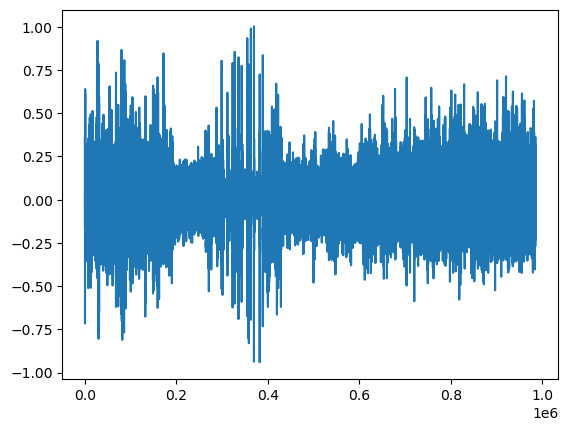

In [7]:
''' ecog '''

ele_rec_bs = pd.read_csv(load_path + "ecog_data_m005.csv")
ele_rec_bs = ele_rec_bs.values
ele_data = ele_rec_bs.T
print("ele_data:", type(ele_data), ele_data.shape)

ele_fp26 = ele_data[26 - 1]
print("ele_fp26:", len(ele_fp26))
plt.plot(ele_fp26)
plt.show()



# ecog figures

============== b_s_idx  0  =================
ele_start_row, ele_end_row: 287500 293700
ele_data_se: (32, 6200)


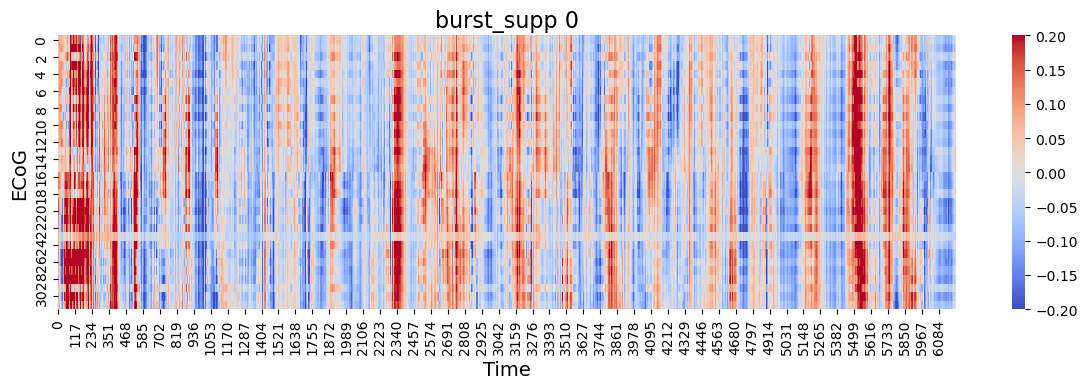

ele_data_se: (32, 6200)


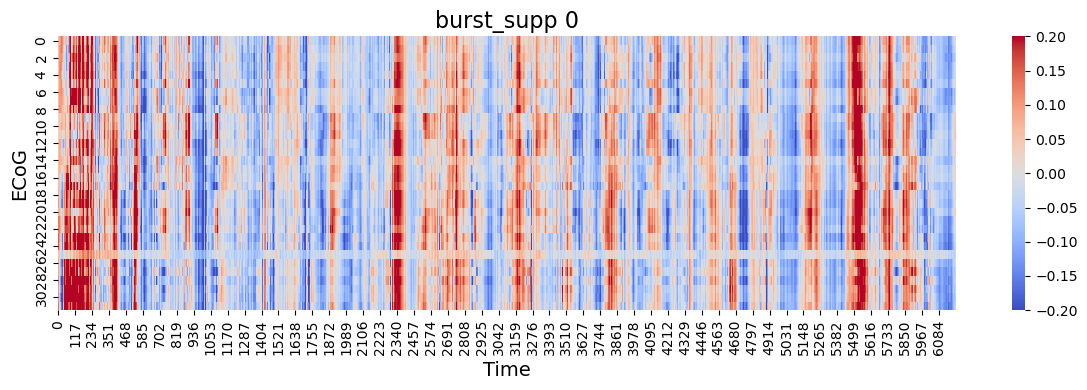

============== b_s_idx  1  =================
ele_start_row, ele_end_row: 298700 303300
ele_data_se: (32, 4600)


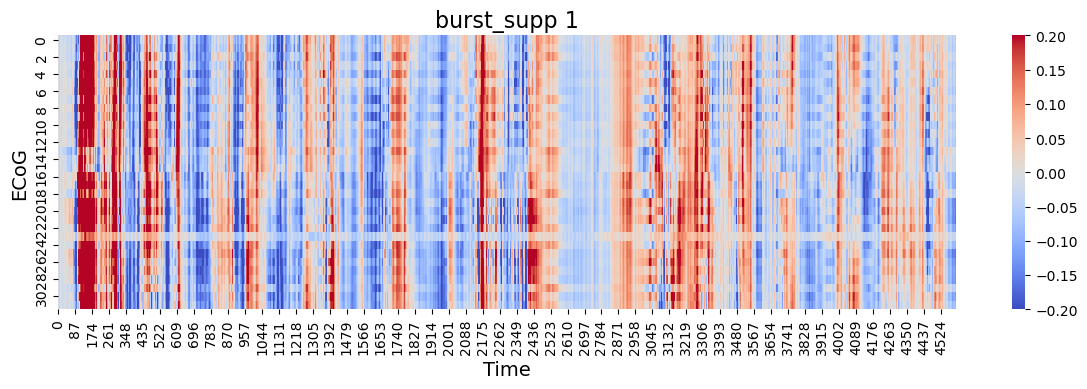

ele_data_se: (32, 4600)


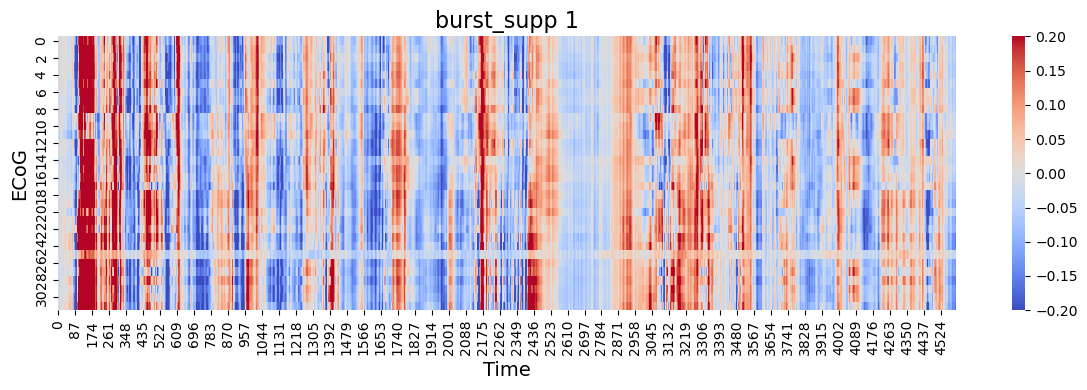

============== b_s_idx  2  =================
ele_start_row, ele_end_row: 311200 314800
ele_data_se: (32, 3600)


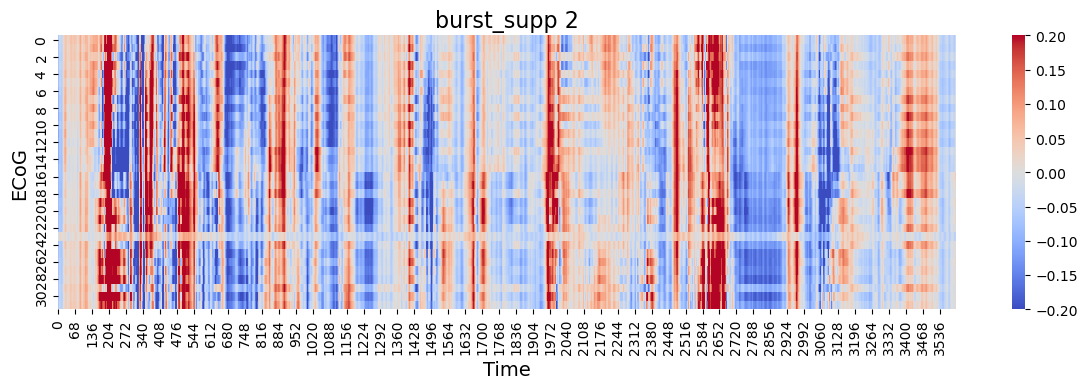

ele_data_se: (32, 3600)


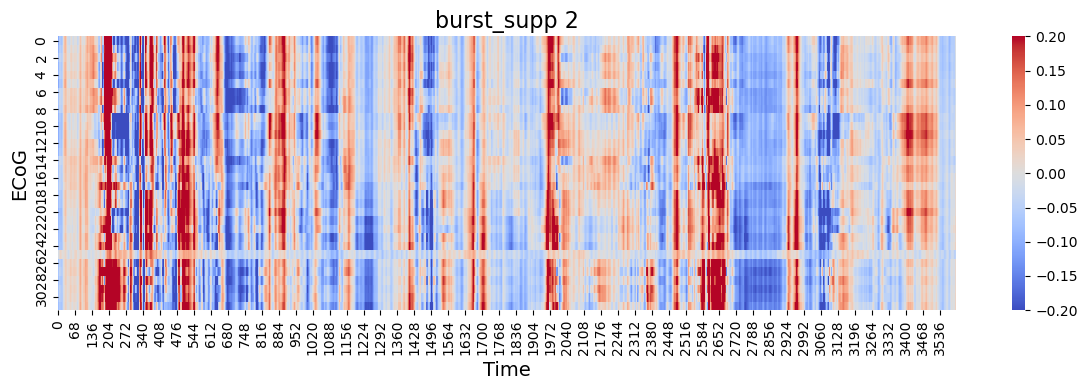

============== b_s_idx  3  =================
ele_start_row, ele_end_row: 322700 324500
ele_data_se: (32, 1800)


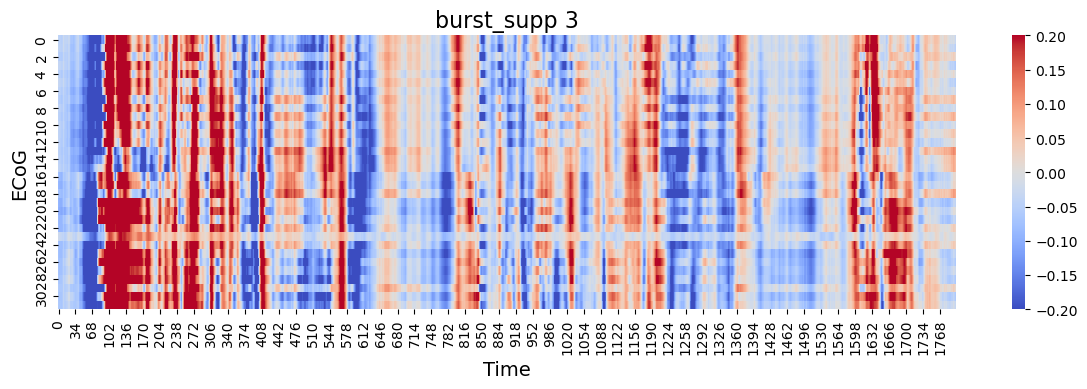

ele_data_se: (32, 1800)


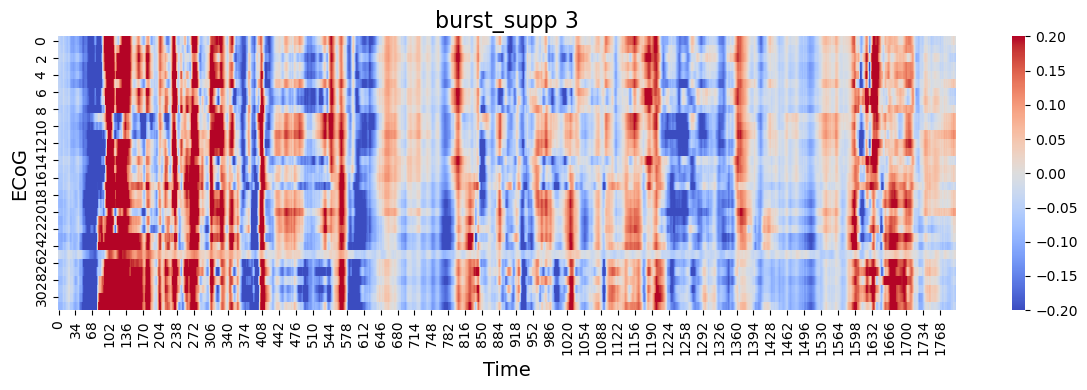

============== b_s_idx  4  =================
ele_start_row, ele_end_row: 327200 329300
ele_data_se: (32, 2100)


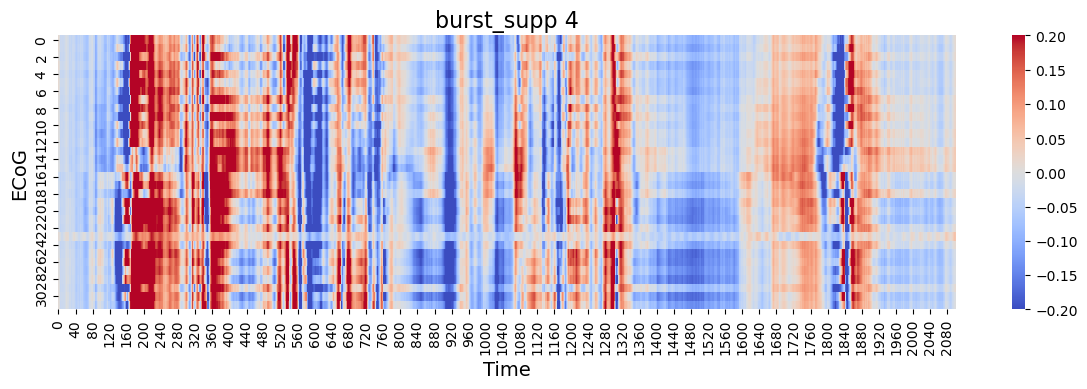

ele_data_se: (32, 2100)


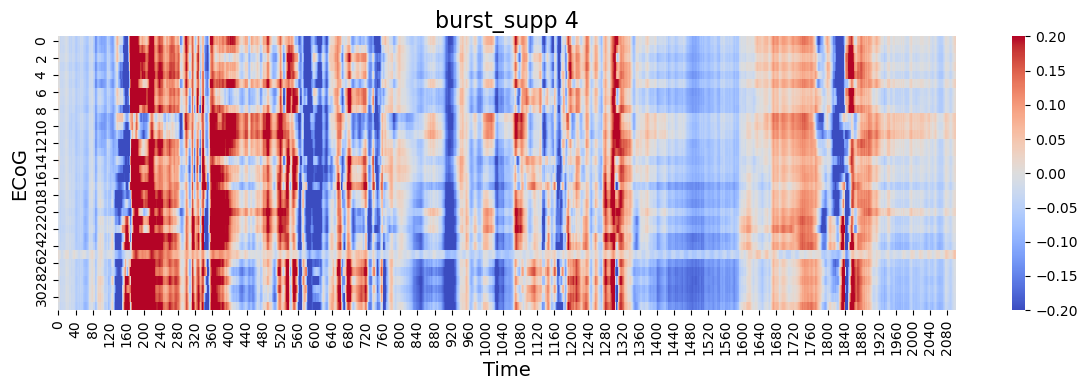

============== b_s_idx  5  =================
ele_start_row, ele_end_row: 335600 337000
ele_data_se: (32, 1400)


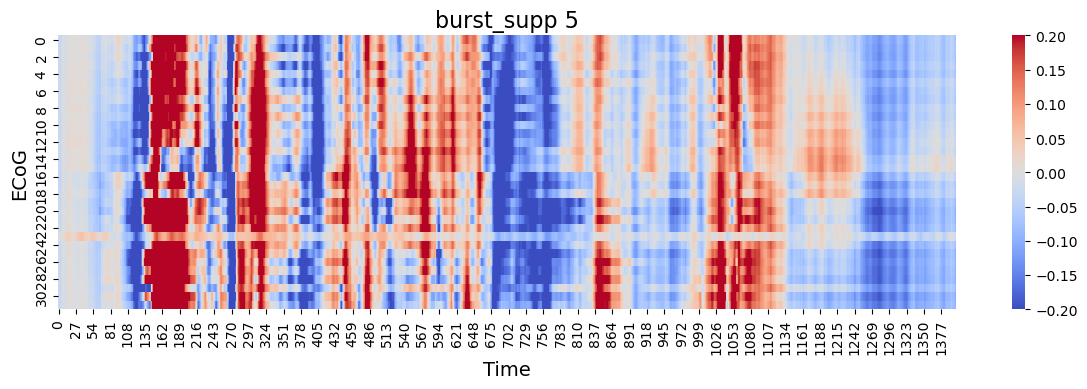

ele_data_se: (32, 1400)


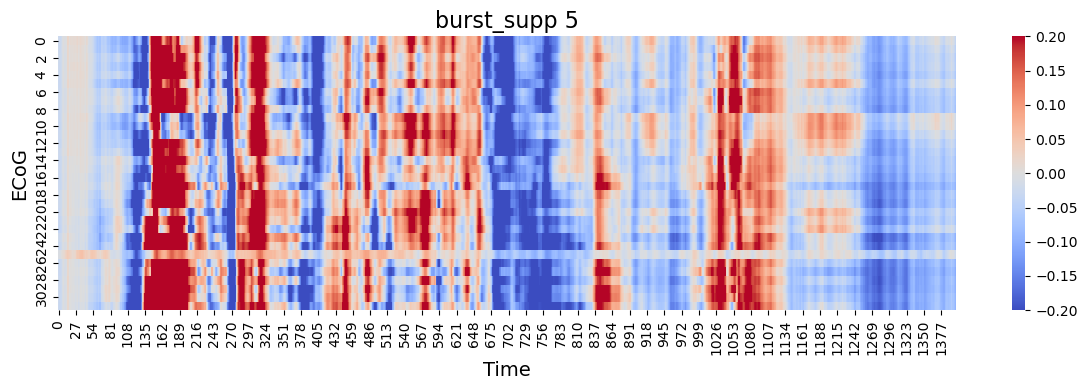

============== b_s_idx  6  =================
ele_start_row, ele_end_row: 342400 344400
ele_data_se: (32, 2000)


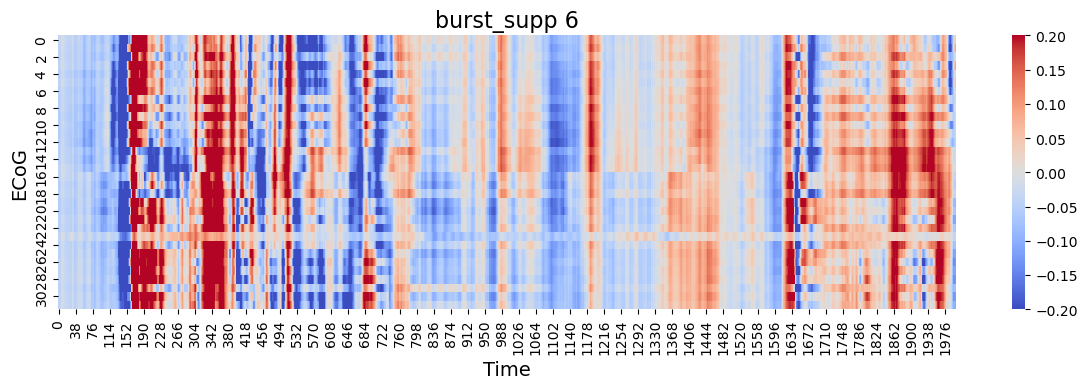

ele_data_se: (32, 2000)


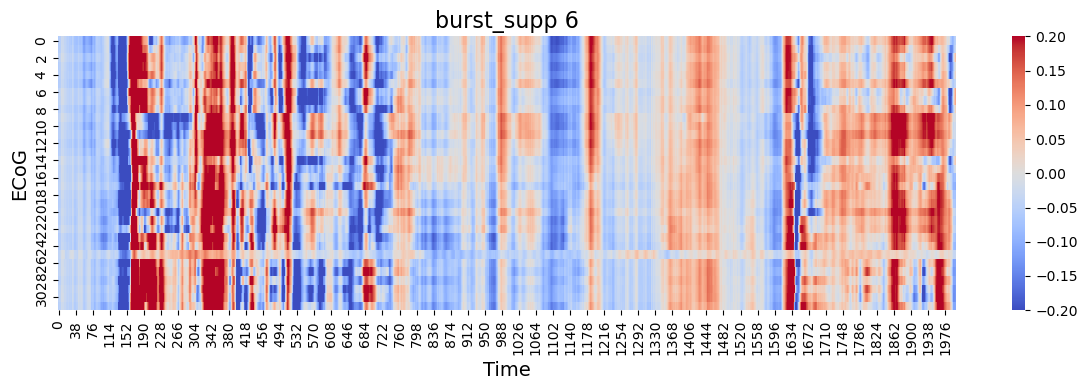

============== b_s_idx  7  =================
ele_start_row, ele_end_row: 354800 355600
ele_data_se: (32, 800)


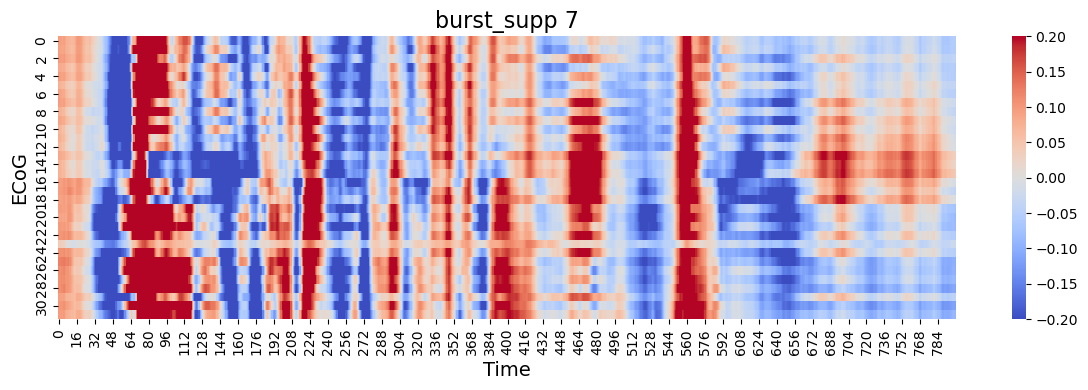

ele_data_se: (32, 800)


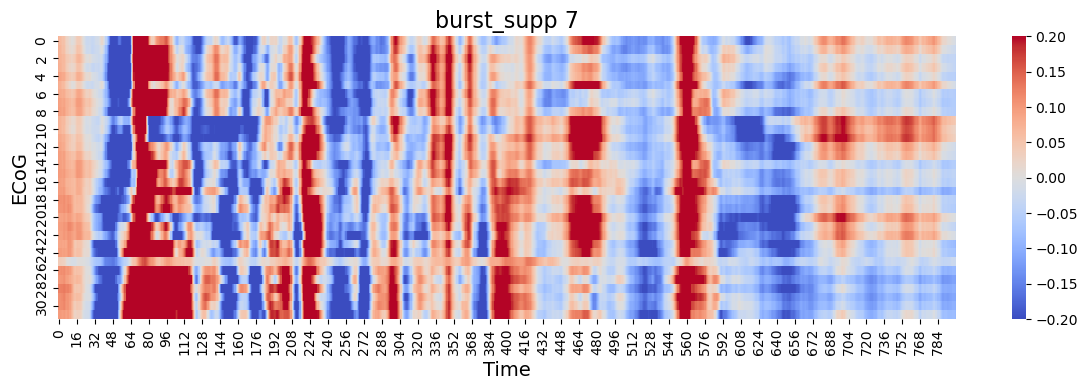

============== b_s_idx  8  =================
ele_start_row, ele_end_row: 357300 357800
ele_data_se: (32, 500)


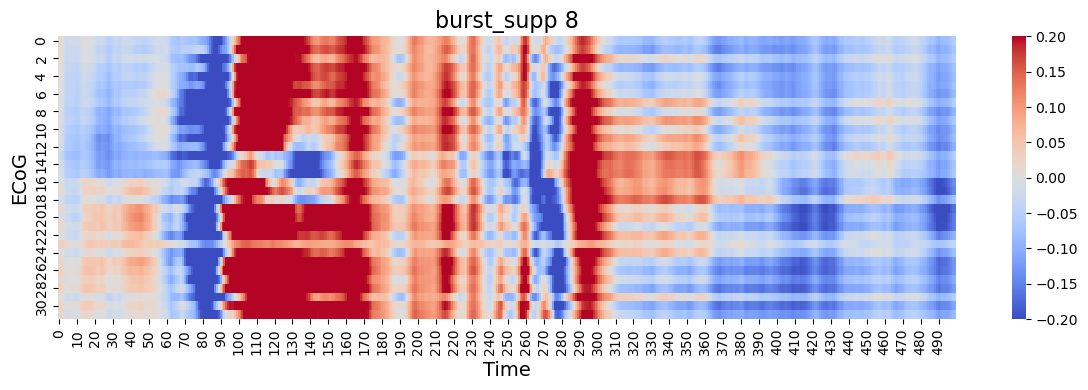

ele_data_se: (32, 500)


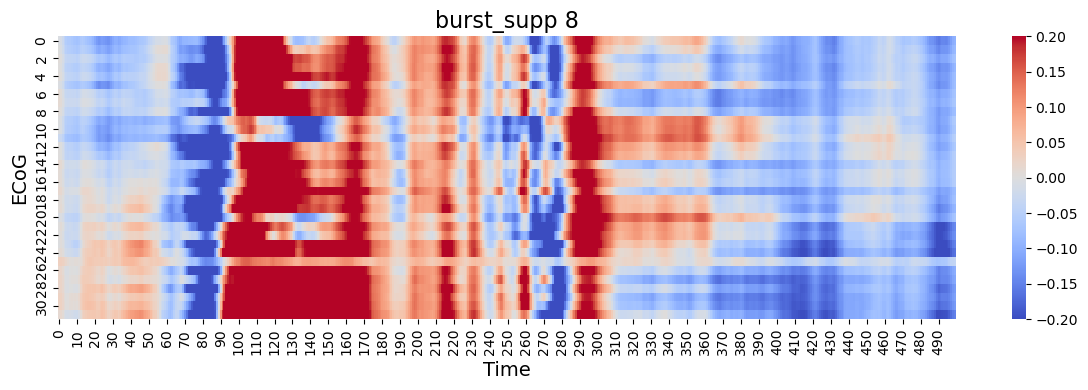

============== b_s_idx  9  =================
ele_start_row, ele_end_row: 358300 358800
ele_data_se: (32, 500)


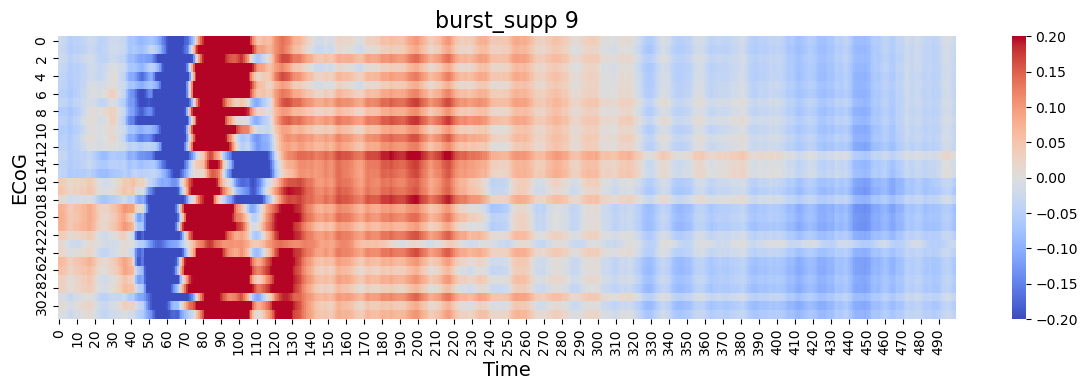

ele_data_se: (32, 500)


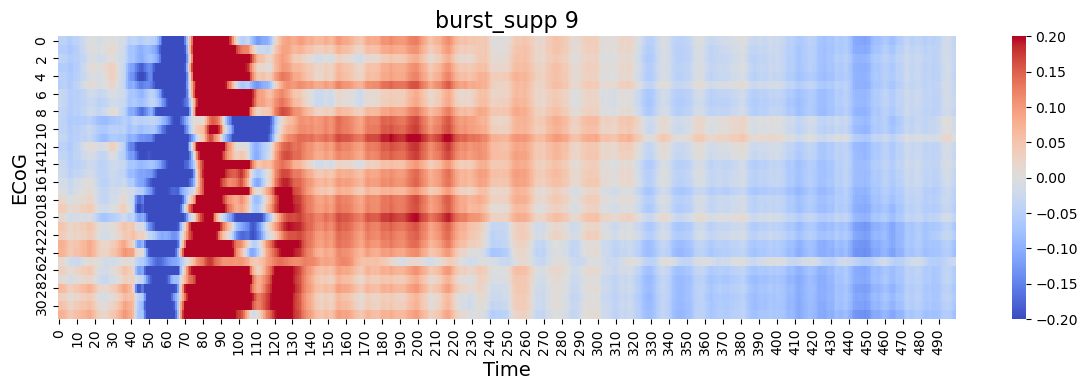

============== b_s_idx  10  =================
ele_start_row, ele_end_row: 362600 363700
ele_data_se: (32, 1100)


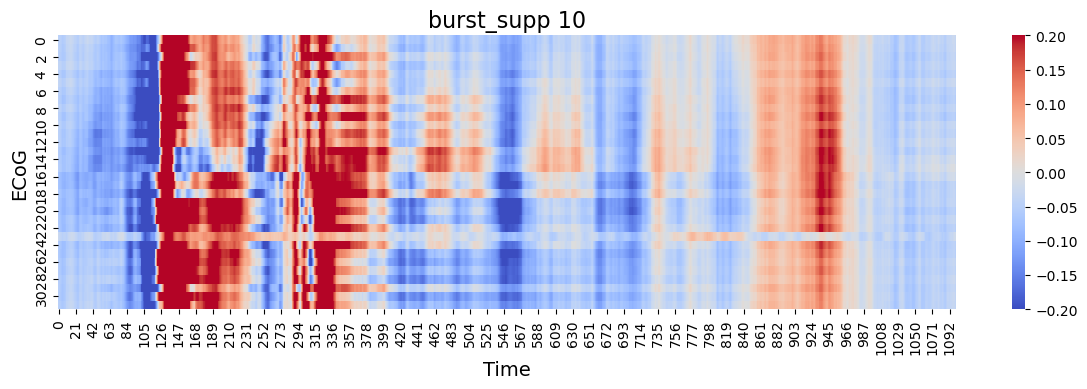

ele_data_se: (32, 1100)


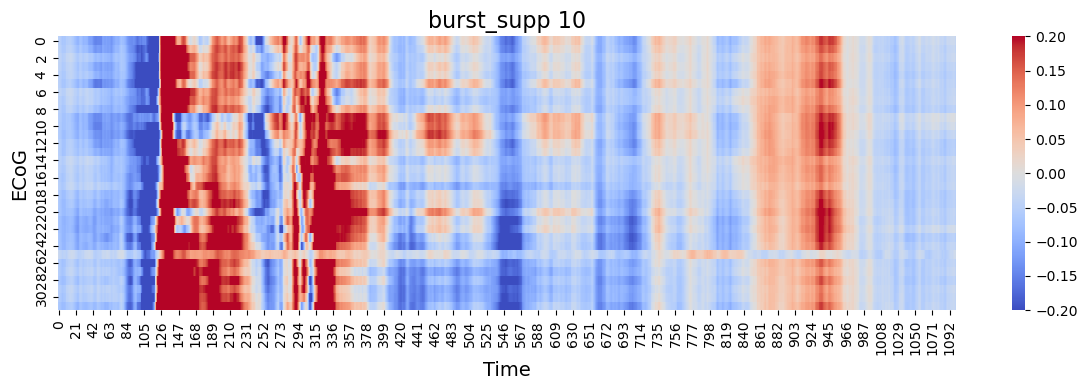

============== b_s_idx  11  =================
ele_start_row, ele_end_row: 369400 370300
ele_data_se: (32, 900)


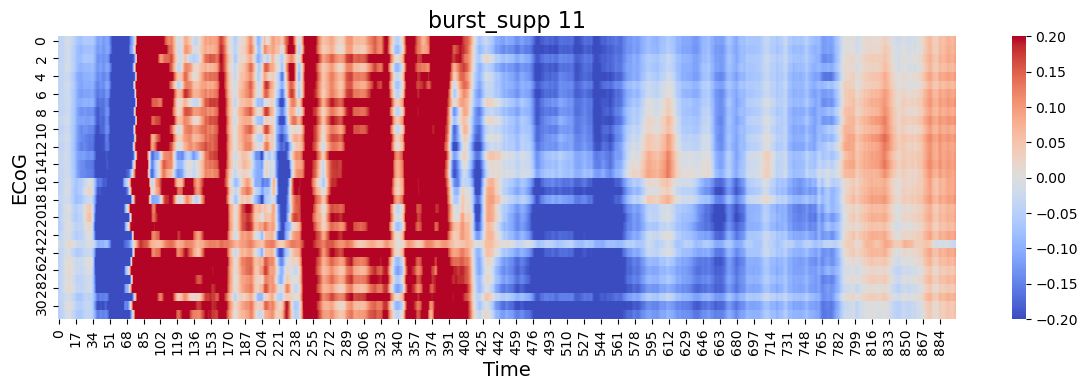

ele_data_se: (32, 900)


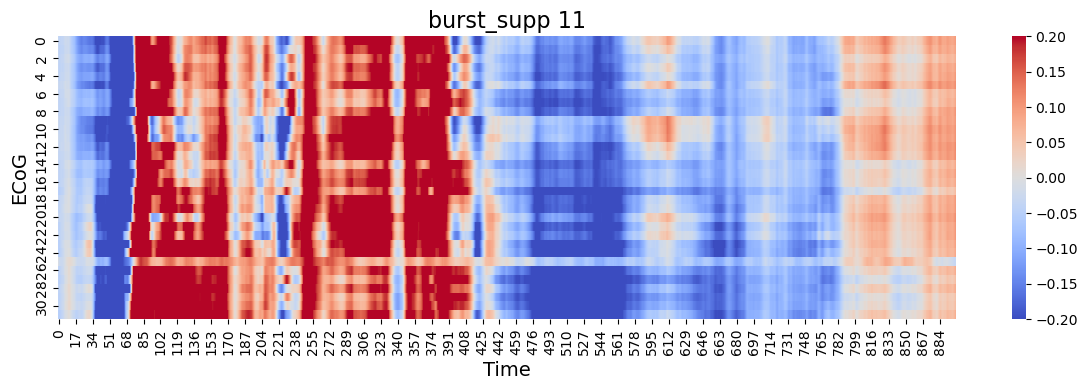

============== b_s_idx  12  =================
ele_start_row, ele_end_row: 381800 382600
ele_data_se: (32, 800)


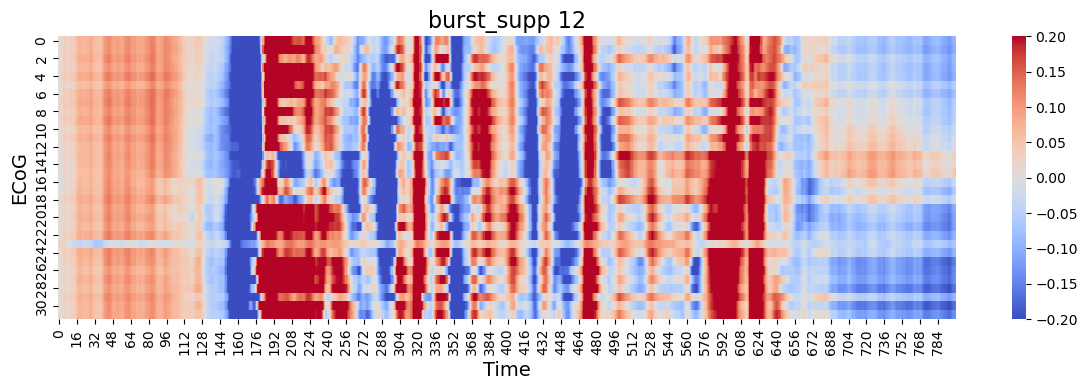

ele_data_se: (32, 800)


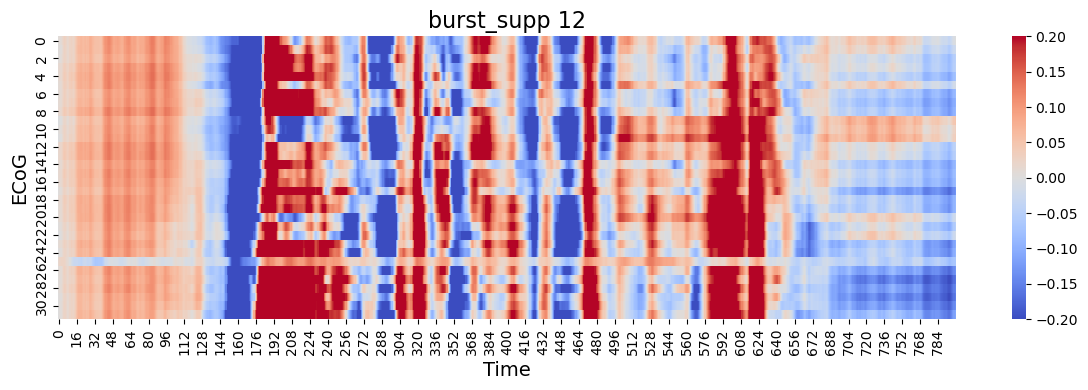

In [14]:
''' calc trace '''

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# parameters
ecog_channel_sort = [13,11,6,9,7,12,4,2,5,16,15,14,10,8,1,3,30,32,25,23,19,18,17,21,20,24,28,31,26,29,27,22]



for b_s_idx in range(len(bs_start_idx)):
    print("============== b_s_idx ", b_s_idx, " =================")
    
    calc_start, calc_end = bs_start_idx[b_s_idx], bs_end_idx[b_s_idx]
    ele_start, ele_end = calc_start / 10 + 34.3, calc_end / 10 + 34.3
    ele_start_row, ele_end_row = int(ele_start * 1000), int(ele_end * 1000)
    print("ele_start_row, ele_end_row:", ele_start_row, ele_end_row)

    # ori order
    cols = [i for i in range(32)]
    ele_data_se = ele_data[cols, ele_start_row : ele_end_row]
    print("ele_data_se:", ele_data_se.shape)
    
    data = pd.DataFrame(ele_data_se) 
    plt.figure(figsize=(12,4), tight_layout = True)
    sns.heatmap(data, cmap = "coolwarm",  vmin = -0.2, vmax = 0.2)
    plt.title("burst_supp " + str(b_s_idx), fontsize = 16)
    plt.xlabel("Time", fontsize = 14)
    plt.ylabel("ECoG", fontsize = 14)
#     plt.savefig(res_path + "multi_channels/eeg_32_channels_burst_index_" + str(b_s_idx) + ".png", bbox_inches='tight')
#     plt.savefig(res_path + "multi_channels/eeg_32_channels_burst_index_" + str(b_s_idx) + ".pdf", bbox_inches='tight')
    plt.show()

    # sorted
    cols = [i - 1 for i in ecog_channel_sort]
    ele_data_se = ele_data[cols, ele_start_row : ele_end_row]
    print("ele_data_se:", ele_data_se.shape)
    
    data = pd.DataFrame(ele_data_se) 
    plt.figure(figsize=(12,4), tight_layout = True)
    sns.heatmap(data, cmap = "coolwarm",  vmin = -0.2, vmax = 0.2)
    plt.title("burst_supp " + str(b_s_idx), fontsize = 16)
    plt.xlabel("Time", fontsize = 14)
    plt.ylabel("ECoG", fontsize = 14)
    plt.savefig(res_path + "multi_channels/eeg_32_channels_burst_index_" + str(b_s_idx) + "_sort.png", bbox_inches='tight')
    plt.savefig(res_path + "multi_channels/eeg_32_channels_burst_index_" + str(b_s_idx) + "_sort.pdf", bbox_inches='tight')
    plt.show()
    

============== ratio  0.8  =================
avg_list: 16 std_list: 16


C:\Users\BBNC\AppData\Local\Temp\ipykernel_43100\3803728350.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,2,1)


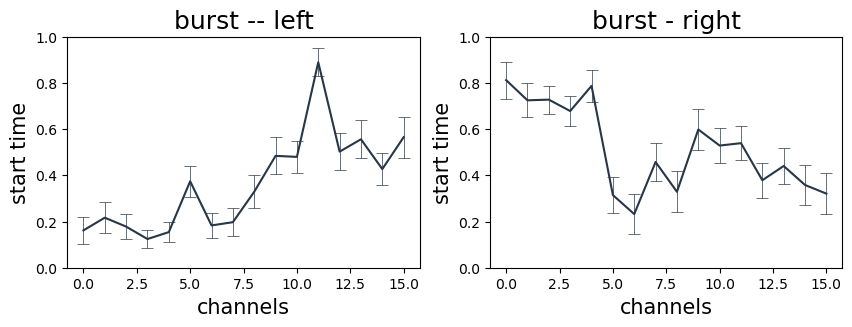

In [23]:
''' calc trace '''

def normalization(data):
    _range = np.max(data) - np.min(data)
    if np.max(data) == np.min(data):
        return [0.5] * len(data)
    else:
        return (data - np.min(data)) / _range

# paeameters
duration_cnt = 19
down_sampling = 10
p_thre = 0.05


ecog_channel_sort = [13,11,6,9,7,12,4,2,5,16,15,14,10,8,1,3,30,32,25,23,19,18,17,21,20,24,28,31,26,29,27,22]


ecog_data_all = []

for ratio in [0.8]:#[0.5,0.6,0.7,0.8,0.9]:
    print("============== ratio ", ratio, " =================")
    for b_s_idx in range(len(bs_start_idx)):
        
        calc_start, calc_end = bs_start_idx[b_s_idx], bs_end_idx[b_s_idx]
        ele_start, ele_end = calc_start / 10 + 34.3, calc_end / 10 + 34.3
        ele_start_row, ele_end_row = int(ele_start * 1000), int(ele_end * 1000)
    
        cols = [i - 1 for i in ecog_channel_sort]
        ele_data_se = ele_data[cols, ele_start_row : ele_end_row]

        start_idx = []
        for ele_single in ele_data_se:
            ele_sort = copy.deepcopy(ele_single)
            ele_sort.sort()
            ele_thre = ele_sort[int(len(ele_sort) * ratio)]
            ele_idx = [i for i in range(len(ele_single)) if ele_single[i] > ele_thre]
            start_idx.append(ele_idx[0])

        ecog_data_all.append(start_idx)

    # final figures
    fig, ax = plt.subplots(figsize = (10,3), dpi= 100,facecolor="w")
    
    ecog_data_all_norm = [normalization(i[:16]) for i in ecog_data_all]
    avg_list = np.mean(ecog_data_all_norm, axis = 0)
    std_list = [i/math.sqrt(19) for i in np.std(ecog_data_all_norm, axis = 0)]
    ax = plt.subplot(1,2,1)
    plt.errorbar(list(range(len(avg_list))),avg_list, yerr = std_list, fmt = '', 
                 ecolor = "#283747", elinewidth = 0.5, color = "#283747", capsize = 4, capthick = 0.5)
    plt.plot(range(len(avg_list)), avg_list, color = "#283747", linewidth = 0.5, alpha = 0.8)
    plt.title("burst -- left", fontsize = 18)
    plt.ylabel("start time", fontsize = 15)
    plt.xlabel("channels", fontsize = 15)
    plt.ylim(0,1)
    
    ecog_data_all_norm = [normalization(i[16:]) for i in ecog_data_all]
    avg_list = np.mean(ecog_data_all_norm, axis = 0)
    std_list = [i/math.sqrt(19) for i in np.std(ecog_data_all_norm, axis = 0)]
    print("avg_list:", len(avg_list), "std_list:", len(std_list))
    ax = plt.subplot(1,2,2)
    plt.errorbar(list(range(len(avg_list))),avg_list, yerr = std_list, fmt = '', 
                 ecolor = "#283747", elinewidth = 0.5, color = "#283747", capsize = 4, capthick = 0.5)
    plt.plot(range(len(avg_list)), avg_list, color = "#283747", linewidth = 0.5, alpha = 0.8)
    plt.title("burst - right", fontsize = 18)
    plt.ylabel("start time", fontsize = 15)
    plt.xlabel("channels", fontsize = 15)
    plt.ylim(0,1)
    plt.savefig(res_path + "multi_channels/ele_32 channels_start_time_radius_burst_all.png", bbox_inches='tight')
    plt.savefig(res_path + "multi_channels/ele_32 channels_start_time_radius_burst_all.pdf", bbox_inches='tight')
    plt.show()

    
